This version makes corrections:
1. Chosen H correctly
2. criteria minimum is best and variance
3. if change/ improvement is too small, drop A
4. state has structure and close to 10^-14 then solve analytically

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
## Define the loss function using the commutator operator
def func1(rho, H, sigma):
    commutator = torch.mm(H, sigma) - torch.mm(sigma, H)  # [H, sigma] = Hσ - σH
    trace_term = torch.trace(torch.mm(rho, commutator))  # Tr(rho * [H, sigma])
    return 0.25 * torch.abs(trace_term) ** 2  # Loss function

# Grad Descent Code with Physical Constraints

In [3]:
## Function is the same as func1 above

## Initialize 2x2 matrix parameters with requires_grad=True
shape = (2, 2)
A = torch.randn(shape, requires_grad=True)  # For constructing H (ensures positive semi-definite)
B = torch.randn(shape, requires_grad=True)  # For constructing rho (ensures positive semi-definite)
C = torch.randn(shape, requires_grad=True)   # Sigma remains unconstrained, but lets just name it C for easy edit later

learning_rate2 = 0.00001
num_iterations2 = 30

## Store function history for visualization
func_history2 = []

In [4]:
## Gradient Descent
for _ in range(num_iterations2):
    learning_rate2 *= 0.8  # Decrease learning rate

    # Construct H = A A^T (Ensuring Positive Semi-Definiteness)
    H2 = torch.mm(A, A.T)

    # Construct ρ = B B^T / Tr(B B^T) (Ensuring Positive Semi-Definiteness & Trace 1)
    BBT = torch.mm(B, B.T)
    rho2 = BBT / torch.trace(BBT)

    # Construct sigma
    sigma2 = C
    
    # Compute function
    loss = func1(rho2, H2, sigma2)
    func_history2.append(loss.item())  # Track function value

    # Compute gradients
    loss.backward()

    # Apply gradient update
    with torch.no_grad():  # No gradient tracking during updates
        A -= learning_rate2 * A.grad
        B -= learning_rate2 * B.grad
        C -= learning_rate2 * C.grad * 0.01

        # Clear gradients for the next step
        A.grad.zero_()
        B.grad.zero_()
        C.grad.zero_()


<IPython.core.display.Javascript object>


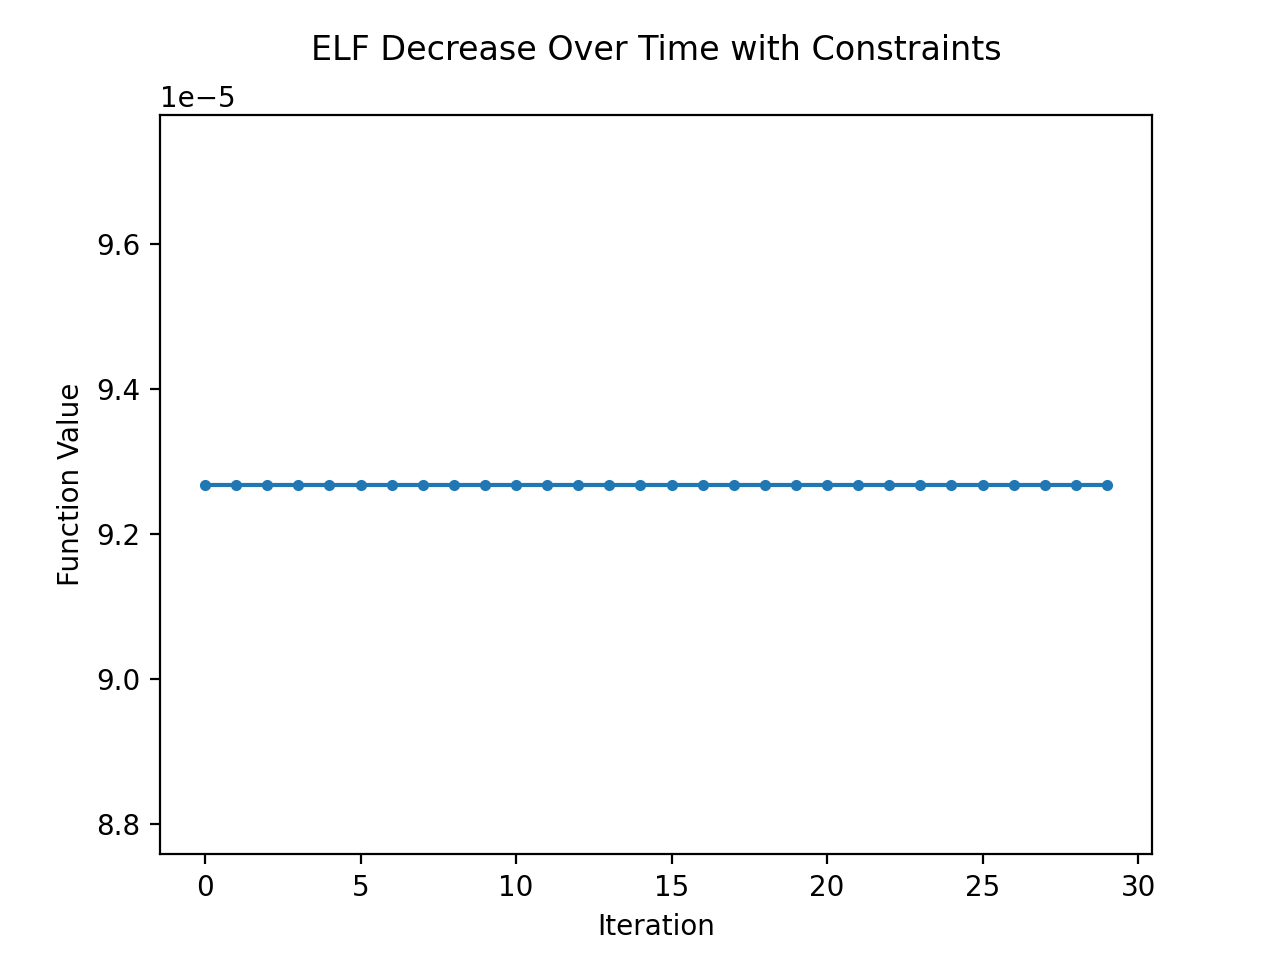


Optimal ρ (rho) =
[[0.5556807  0.04174735]
 [0.04174735 0.4443193 ]]

Optimal H =
[[ 1.6271609  -0.24651304]
 [-0.24651304  0.8793142 ]]

Optimal σ (sigma) =
[[2.1551473  0.95424247]
 [0.6260733  0.32124496]]


In [5]:
## Plot function decay over iterations
plt.figure()
plt.plot(func_history2, marker='.', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Function Value")
plt.title("ELF Decrease Over Time with Constraints", pad=20)
plt.show()

## Print optimal matrices nicely formatted
def print_matrix(name, matrix):
    print(f"\n{name} =\n{matrix.detach().numpy()}")

## Compute final constrained matrices
H_opt = torch.mm(A, A.T)
rho_opt = torch.mm(B, B.T) / torch.trace(torch.mm(B, B.T))
sigma_opt = sigma2

print_matrix("Optimal ρ (rho)", rho_opt)
print_matrix("Optimal H", H_opt)
print_matrix("Optimal σ (sigma)", sigma_opt)


# Seesaw-y Grad Descent with Physical Constraints

In [6]:
# Loss function same as func1

# Initialize learnable matrices:
#   A is used to construct H = A A^T, ensuring H is positive semidefinite.
#   B is used to construct ρ = B B^T / Tr(B B^T), ensuring ρ is a density matrix.
#   sigma remains unconstrained.
shape = (2, 2)
A2 = torch.randn(shape, requires_grad=True)  # leads to H
B2 = torch.randn(shape, requires_grad=True) # leads to rho
C2 = torch.randn(shape, requires_grad=True) # sigma

learning_rate3 = 0.0001
num_iterations3 = 50
func_history3 = []


In [7]:
# Seesaw (alternating) optimization loop:
for i in range(num_iterations3):
    learning_rate3 *= 0.8  # Optionally adjust learning rate

    # -------------------------------------------------
    # Step 1: Update B (thus update ρ) while fixing A and sigma
    # -------------------------------------------------
    with torch.no_grad():
        H3_current = torch.mm(A2, A2.T)
        BBT2 = torch.mm(B2, B2.T)
        rho3_current = BBT2 / torch.trace(BBT2)
        sigma3_current = C2 # no physical constraints
    
    loss = func1(rho3_current, H3_current, sigma3_current)
    func_history3.append(loss.item())
    
    loss.backward(retain_graph=True)
    with torch.no_grad():
        # Update B only if its gradient is not None
        if B2.grad is not None:
            B2 -= learning_rate3 * B2.grad
    if B2.grad is not None:
        B2.grad.zero_()

    # -------------------------------------------------
    # Step 2: Update A (thus update H) while fixing B and sigma
    # -------------------------------------------------
    with torch.no_grad():
        BBT2 = torch.mm(B2, B2.T)
        rho3_current = BBT2 / torch.trace(BBT2)
        H3_current = torch.mm(A2, A2.T)
        sigma3_current = C2 # no physical constraints
        
    loss = func1(rho3_current, H3_current, sigma3_current)
    loss.backward(retain_graph=True)
    with torch.no_grad():
        if A2.grad is not None:
            A2 -= learning_rate3 * A2.grad
    if A2.grad is not None:
        A2.grad.zero_()

    # -------------------------------------------------
    # Step 3: Update sigma while fixing A and B
    # -------------------------------------------------
    with torch.no_grad():
        H3_current = torch.mm(A2, A2.T)
        BBT2 = torch.mm(B2, B2.T)
        rho3_current = BBT2 / torch.trace(BBT2)
        sigma3_current = C2
        
    loss = func1(rho3_current, H3_current, sigma3_current)
    loss.backward()  # For sigma, we don't need retain_graph
    with torch.no_grad():
        if C2.grad is not None:
            C2 -= learning_rate3 * C2.grad
    if C2.grad is not None:
        C2.grad.zero_()


<IPython.core.display.Javascript object>


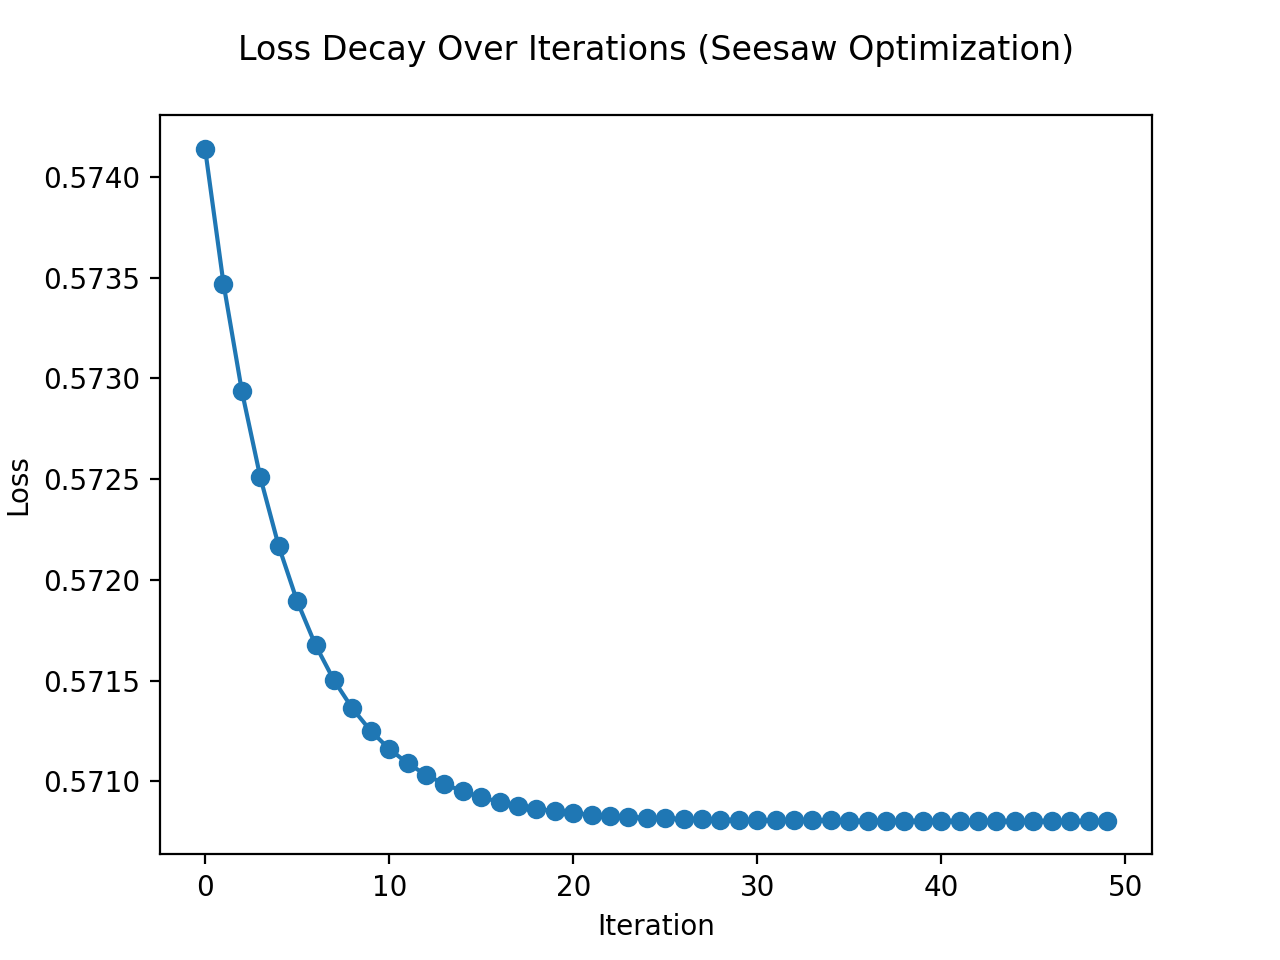


Optimal ρ (rho) =
[[0.9133329  0.19239858]
 [0.19239858 0.08666713]]

Optimal H =
[[ 2.5891948 -1.8117454]
 [-1.8117454  2.2766151]]

Optimal σ (sigma) =
[[-0.20311384 -0.72129947]
 [ 0.24864937 -0.8094958 ]]


In [8]:
# Plot the loss over iterations
plt.figure()
plt.plot(func_history3, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Decay Over Iterations (Seesaw Optimization)", pad=20)
plt.show()

# Compute the final, constrained matrices, 
H_opt3 = torch.mm(A2, A2.T)
rho_opt3 = torch.mm(B2, B2.T) / torch.trace(torch.mm(B2, B2.T))
# sigma is already automatically updated with A and B
sigma_opt3 = C2

# Function to nicely print matrices
def print_matrix(name, matrix):
    print(f"\n{name} =\n{matrix.detach().numpy()}")

print_matrix("Optimal ρ (rho)", rho_opt3)
print_matrix("Optimal H", H_opt3)
print_matrix("Optimal σ (sigma)", sigma_opt3)